In [ ]:
%load_ext autoreload
%autoreload 2

# Multi species model

The [train-crown](https://github.com/martibosch/swiss-urban-trees/blob/main/notebooks/train-crown.ipynb) notebook shows how to use the pre-trained tree crown detection of [DeepForest](https://deepforest.readthedocs.io/en/latest) [1] with our dataset, both for inference as well as how to fine-tune it.

In this notebook, we will show how to not only detect tree crowns but also classify them into different species/groups. Without loss of generality, we will first focus on distinguishing between deciduous and conifer trees (as introduced in the [train-test-split](https://github.com/martibosch/swiss-urban-trees/blob/main/notebooks/train-test-split.ipynb) notebook and annotated accordingly).

In [ ]:
import tempfile
from os import path

import matplotlib.pyplot as plt
import pandas as pd
import torch
from deepforest import evaluate, main, model, utilities

from swiss_urban_trees import deepforest_utils, plot

# for reproducibility
_ = torch.manual_seed(0)

In [ ]:
annot_df_filepath = "../data/raw/sitg-orthophoto-2019-tiles/annot.csv"
tile_dir = "../data/raw/sitg-orthophoto-2019-tiles"

# model args
num_workers = 4
patch_overlap = 0.1
patch_sizes = [400, 600, 800, 1000]
iou_threshold = 0.15

# viz args
# annot_color = [0, 165, 255]
# pred_color = [0, 165, 255]
# _base_plot_kwargs = {"linewidth": 2, "facecolor": "none", "cmap": "tab10"}
# plot_annot_kwargs = dict({"column": "label"}, **_base_plot_kwargs)
# multi_plot_pred_kwargs = dict({"column": "label"}, **_base_plot_kwargs)
# crop_plot_pred_kwargs = dict({"column": "cropmodel_label"}, **_base_plot_kwargs)
plot_kwargs = {"column": "label", "linewidth": 2, "facecolor": "none", "cmap": "Set3"}
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

# train args
epochs = 5
gpus = None  # set to -1 to use all available GPUs

## Read annotations

In [ ]:
annot_gdf = utilities.read_file(pd.read_csv(annot_df_filepath))
annot_gdf.head()

,xmin,ymin,xmax,ymax,label,image_path,geometry
0,300.0,620.0,362.5,705.0,deciduous,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,"POLYGON ((362.5 620, 362.5 705, 300 705, 300 6..."
1,332.5,80.0,375.0,117.5,deciduous,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,"POLYGON ((375 80, 375 117.5, 332.5 117.5, 332...."
2,142.5,412.5,192.5,462.5,deciduous,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,"POLYGON ((192.5 412.5, 192.5 462.5, 142.5 462...."
3,162.5,472.5,255.0,550.0,deciduous,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,"POLYGON ((255 472.5, 255 550, 162.5 550, 162.5..."
4,227.5,447.5,325.0,525.0,deciduous,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,"POLYGON ((325 447.5, 325 525, 227.5 525, 227.5..."


## Multi-species model

The first approach that we will try is to train a single multi-species model. Let us start by loading the Deepforest prebuilt model.

In [ ]:
deepforest_model = main.deepforest(config_args={"workers": num_workers})
deepforest_model.use_release()

Reading config file: /home/martibosch/miniforge3/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml
setting config workers to 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /home/martibosch/miniforge3/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


As suggested [in the DeepForest documentation](https://deepforest.readthedocs.io/en/v1.4.1/user_guide/06_multi_species.html), we can start with the backbone and box prediction portions of the prebuilt model and then train a new classification model (regression head):

In [ ]:
# get label to id mappings (both ways)
label_dict = {label: i for i, label in enumerate(annot_gdf["label"].unique())}
numeric_to_label_dict = {val: label for label, val in label_dict.items()}

# preapre multi-class model
multi_model = main.deepforest(
    label_dict=label_dict,
    config_args={"num_classes": len(label_dict), "workers": num_workers},
)
# load single class backbone into the new multi-class model
multi_model.model.backbone.load_state_dict(deepforest_model.model.backbone.state_dict())
multi_model.model.head.regression_head.load_state_dict(
    deepforest_model.model.head.regression_head.state_dict()
)
# load regression head into the new multi-class model
multi_model = deepforest_utils.retrain_model(
    multi_model, tile_dir, annot_gdf, epochs=epochs, gpus=gpus
)

Reading config file: /home/martibosch/miniforge3/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml
setting config num_classes to 2
setting config workers to 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                  | Params | Mode 
-------------------------------------------------------------
0 | model      | RetinaNet             | 32.2 M | train
1 | iou_metric | IntersectionOverUnion | 0      | train
2 | mAP_metric | MeanAveragePrecision  | 0      | train
-------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.2 M    Total params
128.675   Total estimated model params size (MB)
204       Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|                                                                                                                                         | 0/1 [00:00<?, ?it/s]

Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00,  0.06it/s, v_num=84]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00,  0.06it/s, v_num=84]
--- Model retrained in 91.40 seconds ---


Let us now use this new model for inference (for a single image and patch size):

In [ ]:
img_filename = annot_gdf["image_path"].unique()[0]
# let us try a single patch size to start with
patch_size = 800
multi_pred_gdf = multi_model.predict_tile(
    path.join(tile_dir, img_filename),
    patch_size=patch_size,
    patch_overlap=patch_overlap,
    iou_threshold=iou_threshold,
)
multi_pred_gdf

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:18<00:00,  0.20it/s]
0 predictions in overlapping windows, applying non-max supression
0 predictions kept after non-max suppression


The multi-species model did not predict any tree, which could be due to many issues with our approach - most likely, the main one being that our annotated tile is not enough to train a proper regression head for multi-species classification. At this point, it seems clear that we need to annotate more tiles, nevertheless, let us try an alternative approach first.

## The crop model

Instead of using a single model to detect tree crowns and then classify them into tree species (or groups of species), we can instead use the prebuilt model for tree crown detection and then apply a follow-up model to the predicted bounding boxes. This is the purpose of the [crop model](https://deepforest.readthedocs.io/en/v1.4.1/user_guide/03_cropmodels.html) feature of DeepForest.

We will first use our annotated bounding boxes and tree species labels to extract the corresponding image. The cropped images and labels will then be used to train the crop model (i.e., an [image classification](https://paperswithcode.com/task/image-classification) model mapping each extracted image as a whole to the tree species label:

In [ ]:
crop_model = model.CropModel(num_classes=len(label_dict))
# maybe we could try a different number of epochs here
crop_model.create_trainer(fast_dev_run=True, max_epochs=epochs)

with tempfile.TemporaryDirectory() as tmp_dir:
    crop_model.write_crops(
        tile_dir,
        annot_gdf["image_path"].values,
        annot_gdf[["xmin", "ymin", "xmax", "ymax"]].values,
        annot_gdf["label"].values,
        tmp_dir,
    )
    # the second argument should be a directory with data for evaluation but we do not
    # have that yet
    crop_model.load_from_disk(tmp_dir, tmp_dir)
    crop_model.trainer.fit(crop_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

  | Name             | Type                | Params | Mode 
-----------------------------------------------------------------
0 | model            | ResNet              | 23.5 M | train
1 | accuracy         | MulticlassAccuracy  | 0      | train
2 | total_accuracy   | MulticlassAccuracy  | 0      | train
3 | precision_metric | MulticlassPrecision | 0      | train
4 | metrics          | MetricCollection    | 0      | train
-----------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.75it/s]
idation: |                                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.55it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.55it/s]


We can now combine both models to perform multi-species tree detection:

In [ ]:
img_filenames = pd.Series(annot_gdf["image_path"].unique())
crop_pred_gdf = pd.concat(
    [
        deepforest_model.predict_tile(
            path.join(tile_dir, img_filename),
            patch_size=patch_size,
            patch_overlap=patch_overlap,
            iou_threshold=iou_threshold,
            crop_model=crop_model,
        ).assign(**{"patch_size": patch_size})
        for img_filename in img_filenames
        for patch_size in patch_sizes
    ],
    ignore_index=True,
)
# TODO: better manage crop model label dict
crop_pred_gdf = crop_pred_gdf.assign(
    **{"label": crop_pred_gdf["cropmodel_label"].map({0: "conifer", 1: "deciduous"})}
)

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:43<00:00,  0.47it/s]
602 predictions in overlapping windows, applying non-max supression
499 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:51<00:00,  0.49it/s]
264 predictions in overlapping windows, applying non-max supression
190 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:39<00:00,  0.41it/s]
121 predictions in overlapping windows, applying non-max supression
84 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████

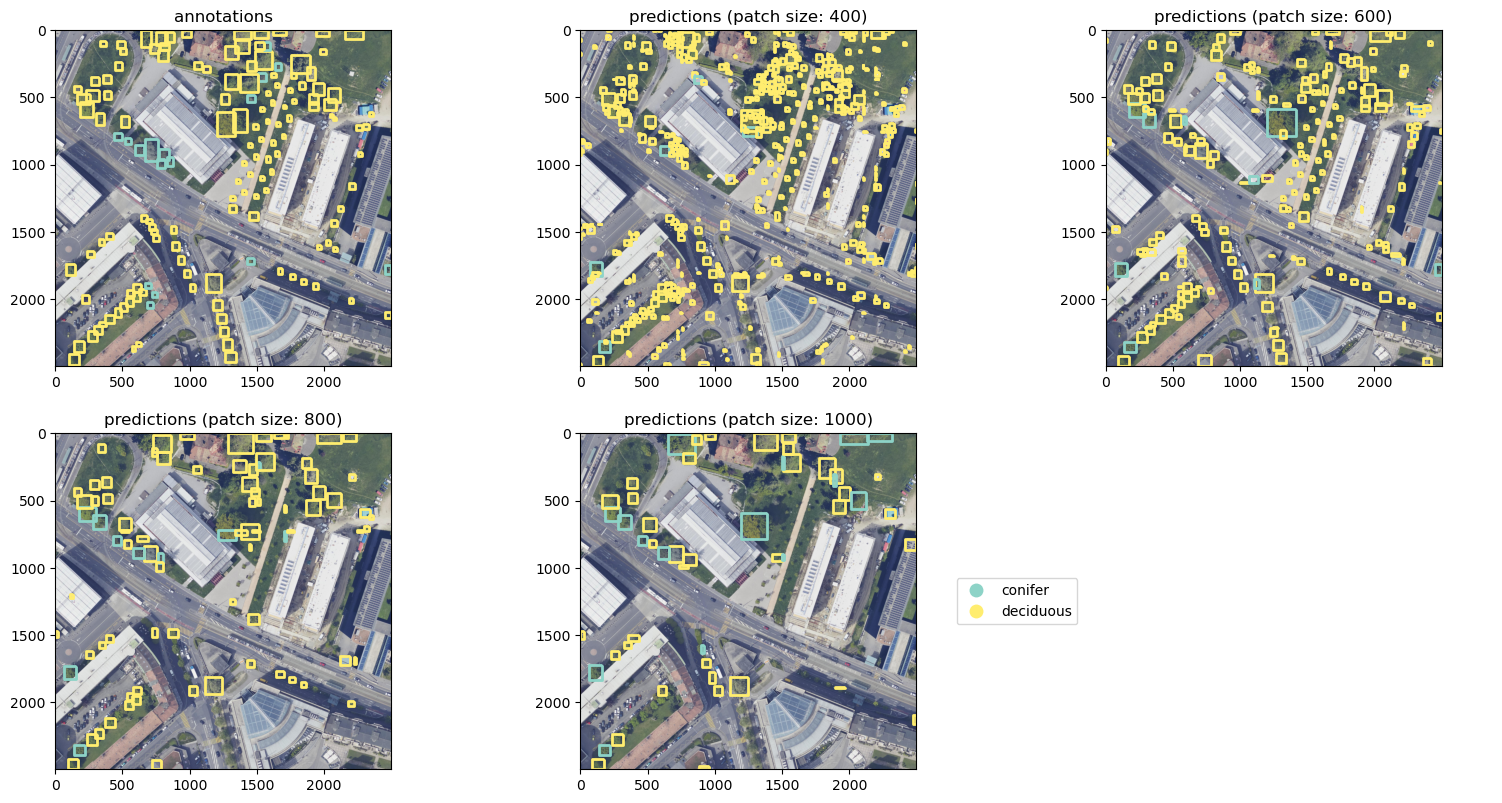

In [ ]:
fig = plot.plot_annot_vs_pred(
    annot_gdf,
    crop_pred_gdf,
    tile_dir,
    plot_annot_kwargs=plot_kwargs,
    plot_pred_kwargs=plot_kwargs,
)

In [ ]:
eval_df = deepforest_utils.multiscale_eval_df(
    crop_pred_gdf, annot_gdf, tile_dir, iou_threshold=iou_threshold
)
eval_df

,patch_size,IoU,recall,precision
0,400,0.530147,0.870748,0.264463
1,600,0.536555,0.809524,0.659218
2,800,0.484751,0.462585,0.809524
3,1000,0.475331,0.299320,0.860000


In [ ]:
class_recall_df = pd.concat(
    [
        evaluate.evaluate_boxes(
            crop_pred_gdf[crop_pred_gdf["patch_size"] == patch_size],
            annot_gdf,
            tile_dir,
            iou_threshold=iou_threshold,
        )["class_recall"].assign(**{"patch_size": patch_size})
        for patch_size in patch_sizes
    ],
    ignore_index=True,
)
class_recall_df

,label,recall,precision,size,patch_size
0,conifer,0.090909,0.333333,11,400
1,deciduous,0.982906,0.920000,117,400
2,conifer,0.083333,0.166667,12,600
3,deciduous,0.953271,0.902655,107,600
4,conifer,0.375000,0.333333,8,800
5,deciduous,0.898305,0.913793,59,800
6,conifer,0.333333,0.166667,6,1000
7,deciduous,0.736842,0.875000,38,1000


As we can see, the precision and recall for "deciduous" trees are high for all patch sizes, nonetheless they are very low for "conifer" trees. This is likely due to the low occurence of "conifer" trees in the annotated data. As shown in the [train-test-split](https://github.com/martibosch/swiss-urban-trees/blob/main/notebooks/train-test-split.ipynb) notebook, we could use the [cantonal tree inventory of Geneva](https://sitg.ge.ch/donnees/sipv-ica-web-public-tot) to select further training tiles, maybe even combine it with active learning criteria such as margin sampling or the like.

#### TODO: train the crop model with the [SITG Orthophoto 2019 at 5 cm](https://sitg.ge.ch/donnees/image-aerienne-ortho-2019-05), without downlsampling to 10 cm for compatibility with [SWISSIMAGE](https://www.swisstopo.admin.ch/en/orthoimage-swissimage-10) within the plain areas and main alpine valleys.

## References

1. Weinstein, B. G., Marconi, S., Aubry‐Kientz, M., Vincent, G., Senyondo, H., & White, E. P. (2020). DeepForest: A Python package for RGB deep learning tree crown delineation. Methods in Ecology and Evolution, 11(12), 1743-1751.

## Annex: evaluation with torchmetrics

Let us now evaluate the model performance using the [torchmetrics](https://torchmetrics.readthedocs.io/en/latest/index.html) package. We will start with the single-class detection case using the current DeepForest evaluation. To that end, we will create modified versions of our predictions and annotations data frames accordingly:

In [ ]:
import time

import numpy as np

# select a single patch size, drop the crop model columns and assign a single label
tree_pred_gdf = (
    crop_pred_gdf[crop_pred_gdf["patch_size"] == 600]
    .drop(["patch_size", "cropmodel_label", "cropmodel_score"], axis="columns")
    .assign(label="Tree")
)
tree_annot_gdf = annot_gdf.assign(label="Tree")

# select a IoU threshold
iou_threshold = 0.4

We will first use the deepforest evaluation:

In [ ]:
# ACHTUNG: pass a copy because the predictions geo-data frame is modified in the
# evaluation
_tree_pred_gdf = tree_pred_gdf.copy()
# single_class_dict = {k: 0 for k, v in label_dict.items()}
tree_dict = {"Tree": 0}
start = time.time()
deepforest_results = evaluate.__evaluate_wrapper__(
    _tree_pred_gdf, tree_annot_gdf, tile_dir, iou_threshold, tree_dict
)
print(f"Elapsed time: {time.time() - start:.2f} s")
deepforest_results["results"]

Elapsed time: 5.08 s


,prediction_id,truth_id,IoU,score,geometry,predicted_label,true_label,image_path,match
0,2,0,0.583791,0.798100,"POLYGON ((362.5 620, 362.5 705, 300 705, 300 6...",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,True
1,14,1,0.479700,0.717700,"POLYGON ((375 80, 375 117.5, 332.5 117.5, 332....",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,True
2,30,2,0.798212,0.613516,"POLYGON ((192.5 412.5, 192.5 462.5, 142.5 462....",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,True
3,42,3,0.834114,0.578586,"POLYGON ((255 472.5, 255 550, 162.5 550, 162.5...",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,True
4,64,4,0.440269,0.470442,"POLYGON ((325 447.5, 325 525, 227.5 525, 227.5...",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,True
...,...,...,...,...,...,...,...,...,...
142,165,142,0.013433,0.126183,"POLYGON ((1430 590, 1430 755, 1322.5 755, 1322...",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,False
143,140,143,0.317757,0.157675,"POLYGON ((1290 475, 1290 550, 1230 550, 1230 4...",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,False
144,118,144,0.000000,0.198607,"POLYGON ((1362.5 325, 1362.5 440, 1260 440, 12...",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,False
145,137,145,0.163865,0.164764,"POLYGON ((1507.5 325, 1507.5 457.5, 1377.5 457...",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,False


Now let us compute the metrics using torchmetrics:

In [ ]:
# TODO: are keys in `ious` sorted based on preds or targets? does that depend on the
# backend used (i.e., pycocotools or faster_coco_eval)?
start = time.time()
torchmetrics_results = deepforest_utils.evaluate(
    tree_pred_gdf,
    tree_annot_gdf,
)
print(f"Elapsed time: {time.time() - start:.2f} s")
torchmetrics_results["results"]

Elapsed time: 0.21 s


,prediction_id,truth_id,IoU,image_path,true_label,geometry,score,predicted_label
0,2,0,0.579121,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,Tree,"POLYGON ((362.5 620, 362.5 705, 300 705, 300 6...",0.798100,Tree
1,14,1,0.479228,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,Tree,"POLYGON ((375 80, 375 117.5, 332.5 117.5, 332....",0.717700,Tree
2,30,2,0.798212,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,Tree,"POLYGON ((192.5 412.5, 192.5 462.5, 142.5 462....",0.613516,Tree
3,42,3,0.835379,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,Tree,"POLYGON ((255 472.5, 255 550, 162.5 550, 162.5...",0.578586,Tree
4,64,4,0.435435,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,Tree,"POLYGON ((325 447.5, 325 525, 227.5 525, 227.5...",0.470442,Tree
...,...,...,...,...,...,...,...,...
142,165,142,0.013680,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,Tree,"POLYGON ((1430 590, 1430 755, 1322.5 755, 1322...",0.126183,Tree
143,140,143,0.317757,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,Tree,"POLYGON ((1290 475, 1290 550, 1230 550, 1230 4...",0.157675,Tree
144,118,144,0.000000,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,Tree,"POLYGON ((1362.5 325, 1362.5 440, 1260 440, 12...",0.198607,Tree
145,137,145,0.160964,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,Tree,"POLYGON ((1507.5 325, 1507.5 457.5, 1377.5 457...",0.164764,Tree


The first thing that we can notice is that computing the metrics is now about x10 times faster. Let us now explore if we get the same results:

In [ ]:
deepforest_eval_df = deepforest_results["results"]
torchmetrics_eval_df = torchmetrics_results["results"]
mismatch_ser = (
    deepforest_eval_df["prediction_id"] != torchmetrics_eval_df["prediction_id"]
)
mismatch_ser.sum()

0

As we can see, we have no mismatches (i.e., annotations that are matched to a different prediction by deepforest and torchmetrics). Let us now compare the IoU values:

In [ ]:
deepforest_eval_df["IoU"].mean(), torchmetrics_eval_df["IoU"].mean()

(0.5354436533153744, 0.5365548)

They are quite close. Since there are no mismatches, the precision and recall should
be the same as well. Let us start by the recall:

In [ ]:
# note that in torchmetrics, recall is a tensor of shape K where K is the number of
# classes
torchmetrics_recall = torchmetrics_results["recall"]
deepforest_results["box_recall"], torchmetrics_recall[0].item()

(0.7278911564625851, 0.7278911564625851)

All good here. Regarding the precision, torchmetrics returns the whole precision-recall curve for a set of recall thresholds (defined as function arguments). We can get the precision for the recall value above by recreating the recall thresholds used in torchmetrics and selecting the precision value for the threshold closest to the recall value:

In [ ]:
# rec_sep = 0.01
rec_sep = deepforest_utils.DEFAULT_REC_SEP
rec_thresholds = np.arange(0, 1 + rec_sep, rec_sep).tolist()
torchmetrics_precision_values = torchmetrics_results["precision"]
# note again that we will get a tensor of shape K where K is the number of classes
# note also that we have to subtract 1 to get the closest smaller recall, otherwise we
# will get a precision of 0
torchmetrics_precision = torchmetrics_precision_values[
    np.argmin(
        np.abs(np.array(rec_thresholds)[:, np.newaxis] - torchmetrics_recall.numpy()),
        axis=0,
    )
    - 1
][0].item()
deepforest_precision = deepforest_results["box_precision"]
print(deepforest_precision, torchmetrics_precision)


# alternatively, we can also get the precision as the latest non-zero value of the
# precision-recall curve:
print(
    deepforest_precision,
    torchmetrics_precision_values[np.nonzero(torchmetrics_precision_values)[-1]][
        0
    ].item(),
)

0.5631578947368421 0.5921787709497207
0.5631578947368421 0.5921787709497207


Note that the differences are likely due to the approximation to one of the discrete recall thresholds, i.e., if we reduce the step size between recall thresholds, we get much closer:

In [ ]:
start = time.time()
rec_sep = 1e-4
precision_values = deepforest_utils.evaluate(
    tree_pred_gdf,
    tree_annot_gdf,
    rec_sep=rec_sep,
)["precision"]
print(f"Elapsed time: {time.time() - start:.2f} s")

print(
    deepforest_precision,
    precision_values[np.nonzero(precision_values)[-1]][0].item(),
)

Elapsed time: 0.27 s
0.5631578947368421 0.5631578947368421


We will now address the case where we have multiple classes. To further increase generality, let us "pretend" that we have annotations and predictions for multiple images:

In [ ]:
def add_fake_image_bboxes(gdf, image_path="foo.jpeg", head_prop=0.9):
    """Add a fake bounding boxes for a fake image path."""
    return pd.concat(
        [
            gdf,
            gdf.assign(image_path=image_path).head(int(gdf.shape[0] * head_prop)),
        ],
        ignore_index=True,
    )


fake_annot_gdf = add_fake_image_bboxes(annot_gdf)
fake_crop_pred_gdf = add_fake_image_bboxes(
    crop_pred_gdf[crop_pred_gdf["patch_size"] == 600]
)

In [ ]:
# ACHTUNG: pass a copy because the predictions geo-data frame is modified in the
# evaluation
_fake_crop_pred_gdf = fake_crop_pred_gdf.copy()
start = time.time()
deepforest_results = evaluate.__evaluate_wrapper__(
    _fake_crop_pred_gdf, fake_annot_gdf, tile_dir, iou_threshold, label_dict
)
print(f"Elapsed time: {time.time() - start:.2f} s")
deepforest_results["results"]

Elapsed time: 6.92 s


,prediction_id,truth_id,IoU,score,geometry,predicted_label,true_label,image_path,match
0,2,0,0.583791,0.798100,"POLYGON ((362.5 620, 362.5 705, 300 705, 300 6...",1,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,True
1,14,1,0.479700,0.717700,"POLYGON ((375 80, 375 117.5, 332.5 117.5, 332....",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,True
2,30,2,0.798212,0.613516,"POLYGON ((192.5 412.5, 192.5 462.5, 142.5 462....",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,True
3,42,3,0.834114,0.578586,"POLYGON ((255 472.5, 255 550, 162.5 550, 162.5...",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,True
4,64,4,0.440269,0.470442,"POLYGON ((325 447.5, 325 525, 227.5 525, 227.5...",0,0,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,True
...,...,...,...,...,...,...,...,...,...
127,77,127,0.791943,0.413465,"POLYGON ((1375 1105, 1375 1137.5, 1347.5 1137....",0,0,foo.jpeg,True
128,24,128,0.758272,0.636173,"POLYGON ((1505 1222.5, 1505 1252.5, 1477.5 125...",0,0,foo.jpeg,True
129,130,129,0.758529,0.174738,"POLYGON ((1460 1057.5, 1460 1087.5, 1432.5 108...",0,0,foo.jpeg,True
130,81,130,0.878972,0.340511,"POLYGON ((1580 1175, 1580 1202.5, 1555 1202.5,...",0,0,foo.jpeg,True


In [ ]:
start = time.time()
torchmetrics_results = deepforest_utils.evaluate(
    fake_crop_pred_gdf,
    fake_annot_gdf,
)
print(f"Elapsed time: {time.time() - start:.2f} s")
torchmetrics_results["results"]

Elapsed time: 0.44 s


,prediction_id,truth_id,IoU,image_path,true_label,geometry,score,predicted_label
0,169,0,0.024610,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,deciduous,"POLYGON ((362.5 620, 362.5 705, 300 705, 300 6...",0.122284,deciduous
1,10,1,0.479228,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,deciduous,"POLYGON ((375 80, 375 117.5, 332.5 117.5, 332....",0.745614,deciduous
2,26,2,0.798212,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,deciduous,"POLYGON ((192.5 412.5, 192.5 462.5, 142.5 462....",0.631127,deciduous
3,37,3,0.835379,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,deciduous,"POLYGON ((255 472.5, 255 550, 162.5 550, 162.5...",0.597186,deciduous
4,59,4,0.435435,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,deciduous,"POLYGON ((325 447.5, 325 525, 227.5 525, 227.5...",0.502739,deciduous
...,...,...,...,...,...,...,...,...
260,3,3,0.000000,foo.jpeg,deciduous,"POLYGON ((2215 1995, 2215 2030, 2182.5 2030, 2...",0.791564,conifer
261,4,4,0.000000,foo.jpeg,deciduous,"POLYGON ((2495 2100, 2495 2145, 2455 2145, 245...",0.779676,deciduous
262,5,5,0.000000,foo.jpeg,conifer,"POLYGON ((2500 1745, 2500 1812.5, 2452.5 1812....",0.773179,deciduous
263,6,6,0.000000,foo.jpeg,deciduous,"POLYGON ((1975 1597.5, 1975 1625, 1950 1625, 1...",0.768683,deciduous


Note that in this case we cannot even compare the data frames because they have different numbers of rows. This is because in torchmetrics, the evaluation is done for each class separately. This may make sense if we are detecting very distinct classes with potentially very little inter-class confusion (e.g., cars and people in a street scene), but in the DeepForest tree detection case, it may make more sense to evaluate all classes together (especially since it is likely that the multi-species classification is done by a separate model once the tree crowns are obtained). In any case, this behavior can likely be controlled by modifying the parameters of [the `coco_eval` variable in the `MeanAveragePrecision.compute` method](https://github.com/Lightning-AI/torchmetrics/blob/master/src/torchmetrics/detection/mean_ap.py#L539) (e.g, [the `useCats` attribute](https://github.com/MiXaiLL76/faster_coco_eval/blob/main/faster_coco_eval/core/cocoeval.py#L627), but this would require modifying torchmetrics and would likely depend on the backend used (i.e., pycocotools or faster_coco_eval).

We can see that if we evaluate the classes together, we get the same results:

In [ ]:
torchmetrics_results["results"]["prediction_id"]

0        2
1       14
2       30
3       42
4       64
      ... 
274     77
275     24
276    130
277     81
278     58
Name: prediction_id, Length: 279, dtype: int64

In [ ]:
start = time.time()
torchmetrics_results = deepforest_utils.evaluate(
    fake_crop_pred_gdf.assign(label="Tree"),
    fake_annot_gdf.assign(label="Tree"),
)
# we need to reset the index to compare data frames because deepforest starts from 0 at
# each image
deepforest_eval_df = deepforest_results["results"].reset_index(drop=True)
print(f"Elapsed time: {time.time() - start:.2f} s")
(
    deepforest_eval_df["prediction_id"]
    != torchmetrics_results["results"]["prediction_id"]
).sum()

Elapsed time: 0.86 s


0

Therefore, an alternative would be to create a custom method that first recreates the evaluation data frame considering all classes together and then evaluates the precision and recall for each class separately, e.g.:

In [ ]:
_torchmetrics_eval_df = torchmetrics_results["results"].copy()
# set the true label from the original annotations
_torchmetrics_eval_df["true_label"] = fake_annot_gdf["label"]
# set the predicted labels from the predictions
_torchmetrics_eval_df = (
    _torchmetrics_eval_df.drop("predicted_label", axis="columns")
    .merge(fake_crop_pred_gdf[["label"]], left_on="prediction_id", right_index=True)
    .rename(columns={"label": "predicted_label"})
)
_torchmetrics_eval_df

,prediction_id,truth_id,IoU,image_path,true_label,geometry,score,predicted_label
0,2,0,0.579121,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,deciduous,"POLYGON ((362.5 620, 362.5 705, 300 705, 300 6...",0.798100,conifer
1,14,1,0.479228,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,deciduous,"POLYGON ((375 80, 375 117.5, 332.5 117.5, 332....",0.717700,deciduous
2,30,2,0.798212,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,deciduous,"POLYGON ((192.5 412.5, 192.5 462.5, 142.5 462....",0.613516,deciduous
3,42,3,0.835379,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,deciduous,"POLYGON ((255 472.5, 255 550, 162.5 550, 162.5...",0.578586,deciduous
4,64,4,0.435435,2499724.7_1119593.6_2499974.7_1119843.6.jpeg,deciduous,"POLYGON ((325 447.5, 325 525, 227.5 525, 227.5...",0.470442,deciduous
...,...,...,...,...,...,...,...,...
274,77,127,0.790196,foo.jpeg,deciduous,"POLYGON ((1375 1105, 1375 1137.5, 1347.5 1137....",0.413465,deciduous
275,24,128,0.772059,foo.jpeg,deciduous,"POLYGON ((1505 1222.5, 1505 1252.5, 1477.5 125...",0.636173,deciduous
276,130,129,0.796078,foo.jpeg,deciduous,"POLYGON ((1460 1057.5, 1460 1087.5, 1432.5 108...",0.174738,deciduous
277,81,130,0.894085,foo.jpeg,deciduous,"POLYGON ((1580 1175, 1580 1202.5, 1555 1202.5,...",0.340511,deciduous


Now again we would have no mismatches:

In [ ]:
(deepforest_eval_df["prediction_id"] != _torchmetrics_eval_df["prediction_id"]).sum()

0

and we can compute the class recall using deepforest:

In [ ]:
evaluate.compute_class_recall(_torchmetrics_eval_df)

,label,recall,precision,size
0,conifer,0.096774,0.200000,31
1,deciduous,0.951613,0.893939,248


and compare it to the results using the original DeepForest evaluation:

In [ ]:
deepforest_results["class_recall"]

,label,recall,precision,size
0,conifer,0.100000,0.181818,20
1,deciduous,0.950276,0.905263,181


the difference is due to the fact that the [`evaluate_boxes` method only uses matches over the given IoU threshold](https://github.com/weecology/DeepForest/blob/main/src/deepforest/evaluate.py#L214-L215) to compute the class recall:

In [ ]:
evaluate.compute_class_recall(
    _torchmetrics_eval_df[_torchmetrics_eval_df["IoU"] > iou_threshold]
)

,label,recall,precision,size
0,conifer,0.100000,0.181818,20
1,deciduous,0.950276,0.905263,181
